In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-08 16:45:54,225]-config_variable.py-INFO -Loading the environment Variable
[2025-12-08 16:45:54,230]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel,Field #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.

from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser


parser = StrOutputParser()

from langgraph.checkpoint.memory import InMemorySaver #this will save the converstion history in ram memory
from langchain_core.runnables import RunnableConfig   #this will help to induce the thread_id or user identification in converstion

## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002A7848B9ED0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002A784F1DF90>, root_client=<openai.OpenAI object at 0x000002A7848BA500>, root_async_client=<openai.AsyncOpenAI object at 0x000002A7848B9E40>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A785016FB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A785051A50>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

In [8]:
import sqlite3

#now forming connection with database.
db_connection = sqlite3.connect(database="raishsample.db"
                                ,check_same_thread=False)

db_connection

In [9]:
from langgraph.checkpoint.sqlite import SqliteSaver #this class we used to save conversation in database
memory = SqliteSaver(conn=db_connection)
memory

## building different type of complex workflows using LangGraph

### 1) building Persistence Database Memory workflow

#### defining state or memory schema for this workflow

In [10]:
from langgraph.graph.message import add_messages
class ConversationalSchema(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages] #operator.add

In [11]:
def ConversationalNode(state:ConversationalSchema)->ConversationalSchema:
    #now fetching the latest user query or human message from state.
    user_query = state['messages']
    
    #now converting dynamic user query to structure instruction prompt.
    prompt = PromptTemplate(
        template="""
        You are an expert conversational AI assistant.

        Your task:
        - Understand the user's intent clearly
        - Respond in a natural, friendly, and helpful conversational tone
        - Give a clear, concise, and accurate answer
        - If the query is ambiguous, politely ask for clarification
        - Do NOT hallucinate or assume missing details

        User query:
        {user_query}

        Answer:
                """,
                input_variables=['user_query']
    )
    
    #forming sequential chain to execute the task.
    chain = prompt | model2
    
    #now invoking chain to perform action.
    result = chain.invoke(input={"user_query":user_query})
    
    
    #now adding this AImsg or updating to msg state 
    return {
        'messages': [result]
    }
    

In [12]:
#now building the object for stategraph class.
graph = StateGraph(state_schema=ConversationalSchema)
graph

In [13]:
#now adding the nodes or edges to graph.
graph.add_node(node="ConversationalNode",action=ConversationalNode)
graph.add_edge(start_key=START,end_key="ConversationalNode")
graph.add_edge(start_key="ConversationalNode",end_key=END)

In [14]:
config1 : RunnableConfig = {"configurable":{'thread_id':1}}

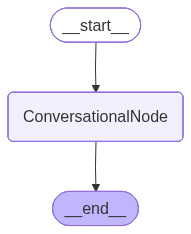

In [15]:
#now compiling the workflow and making ready.
workflow = graph.compile(checkpointer=memory)
workflow

In [16]:
#now passing the inital state to above workflow.
human_msg = [HumanMessage("How are You?")]

state = ConversationalSchema(messages=human_msg)

#passing these state to workflow (so invoking it).
response = workflow.invoke(input=state,config=config1)

for msg in response['messages']:
    msg.pretty_print()

[2025-12-08 16:45:56,139]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
================================ Human Message =================================

How are You?
================================== Ai Message ==================================

I'm doing well, thank you for asking. It's great to chat with you. Is there anything specific you'd like to talk about or any questions you have that I can help with?
================================ Human Message =================================

How are You?
================================== Ai Message ==================================

It looks like we're starting a conversation. You asked how I'm doing, and I'm happy to report that I'm functioning well, thank you for asking. I'm a large language model, so I don't have feelings in the same way humans do, but I'm always ready to chat and help with any questions or topics you'd like to discuss.

Is there something specific on your m

# iterating the workflow for conversation

In [ ]:
thread_id = "3"
while(True):
    #taking the human message.
    user = input("You: ")
    print("Human: ",user)
    
    
    if user.lower() in ["exit", "quit", "bye"]:
        print("Bot: Bye! Have a great day 😊")
        break
    
    else:
        
        config2 : RunnableConfig = {"configurable":{'thread_id':thread_id}}

        #passing these state to workflow (so invoking it).
        response = workflow.invoke(input={'messages':[HumanMessage(content=user)]},config=config2)
        print('Bot: ', response['messages'][-1].content)

Human:  hello my name is raees
[2025-12-08 16:46:07,629]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
AI:  Hello Raees, nice to meet you. It's great to hear your name. Is there something specific you'd like to talk about or ask, or would you like to chat and get to know each other better?
Human:  can you tell me about china in one line
[2025-12-08 16:46:24,840]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
AI:  Hello Raees, I'd be happy to help you with your question about China. Here's a one-line summary: China is the world's most populous country, with a vast territory, rich history, and a rapidly growing economy, known for its ancient civilization, stunning landscapes, and modern megacities. Is there anything else you'd like to know about China or would you like to explore other topics?
Human:  how far china is wrt to india
[2025-12-08 16:46:49,081]-_client.py-INFO -HTTP 